In [19]:
import numpy as np
np.random.seed(42)
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Dropout, BatchNormalization
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

import warnings
warnings.filterwarnings('ignore')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import os
os.environ['OMP_NUM_THREADS'] = '10'

import matplotlib.pyplot as plt
%matplotlib inline

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7563029685519436944
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 271450112
locality {
  bus_id: 1
}
incarnation: 9351909091682484437
physical_device_desc: "device: 0, name: Graphics Device, pci bus id: 0000:01:00.0"
]


In [7]:
EMBEDDING_FILE = '../../../../Downloads/fasttext/wiki.en.vec'

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')


In [28]:
train = pd.read_csv('../data/train.csv').fillna(' ')
test = pd.read_csv('../data/test.csv').fillna(' ')

train_text = train['comment_text']
test_text = test['comment_text']

all_text = pd.concat([train_text, test_text])

y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_train = train["comment_text"].fillna("fillna").values
X_test = test["comment_text"].fillna("fillna").values

In [29]:
# X_train = train["comment_text"].fillna("fillna").values
# y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
# X_test = test["comment_text"].fillna("fillna").values

In [30]:
# # original values
# max_features = 25000
# maxlen = 100
# embed_size = 300

# original values
max_features = 50000
maxlen = 250
embed_size = 300


# tokenizer = text.Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(X_train) + list(X_test))
# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)
# x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
# x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(all_text.values)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)


In [31]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector



In [44]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))


# https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x, batch_size=1024)
        
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val, batch_size=1024)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,6)),str(round(roc_val,6))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
    
# callbacks=[roc_callback(training_data=(x_train, y_train),validation_data=(x_test, y_test))])

In [13]:
def get_model(learning_rate=0.01, lr_decay=0.00001, drop_out=0.2):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    
    # try adding some dropout
    x = Dropout(drop_out)(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    
    # more dropout
    x = Dropout(drop_out)(x)
    outp = Dense(1, activation="sigmoid")(conc)
    
    # configure optimizer
    _optimizer = Adam(lr=learning_rate, decay=lr_decay)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer=_optimizer,
                  metrics=['accuracy'])

    return model

In [14]:
def get_model2(learning_rate=0.001, lr_decay=0.00001, drop_out=0.2):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    
    # try adding some dropout
    x = Dropout(drop_out)(x)
    
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    
    # try adding some dropout
    x = Dropout(drop_out)(x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    
    # more dropout
    x = Dropout(drop_out)(x)
    outp = Dense(6, activation="sigmoid")(conc)
    
    # configure optimizer
    _optimizer = Adam(lr=learning_rate, decay=lr_decay)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer=_optimizer,
                  metrics=['accuracy'])

    return model

In [15]:
def get_model3(learning_rate=0.001, lr_decay=0.00001, drop_out=0.2):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(60, return_sequences=True))(x)
        
    x = Bidirectional(GRU(60, return_sequences=True))(x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    
    # more dropout
    x = Dropout(drop_out)(x)
    outp = Dense(6, activation="sigmoid")(conc)
    
    # configure optimizer
    _optimizer = Adam(lr=learning_rate, decay=lr_decay)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer=_optimizer,
                  metrics=['accuracy'])

    return model

In [32]:
def get_model4(learning_rate=0.001, lr_decay=0.00001, drop_out=0.2):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(drop_out)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
#     x = BatchNormalization()(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    
    outp = Dense(1, activation="sigmoid")(conc)
    
    # configure optimizer
    _optimizer = Adam(lr=learning_rate, decay=lr_decay)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer=_optimizer,
                  metrics=['accuracy'])

    return model

In [47]:
model = get_model4(learning_rate=0.001, lr_decay=0, drop_out=0.175)

# dropout:  0.0    ROC AUC:  0.984483  Epochs = 2  lr_decay = 0.0001
# dropout:  0.1    ROC AUC:  0.984710  Epochs = 3  lr_decay = 0.0001
# dropout:  0.15   ROC AUC:  0.985498  Epochs = 3  lr_decay = 0.0001
# dropout:  0.2    ROC AUC:  0.985565  Epochs = 3  lr_decay = 0.0
# dropout:  0.2    ROC AUC:  0.985754  Epochs = 3  lr_decay = 0.0001
# dropout:  0.25   ROC AUC:  0.985583  Epochs = 3  lr_decay = 0.0001
# dropout:  0.3    ROC AUC:  0.000000  Epochs = 3  lr_decay = 0.0001



# dropout:  0.2    ROC AUC:  0.985565  Epochs = 2  lr_decay = 0.0  batch=32
# dropout:  0.2    ROC AUC:  0.986987  Epochs = 2  lr_decay = 0.0  batch=32

# print(model.summary())

batch_size = 32
epochs = 3

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train[:, 1], train_size=0.90, random_state=1337)

RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[roc_callback(training_data=(X_tra, y_tra),validation_data=(X_val, y_val))],
                 verbose=1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 1380s 10ms/step - loss: 0.0266 - acc: 0.9898 - val_loss: 0.0209 - val_acc: 0.9909
roc-auc: 0.994176 - roc-auc_val: 0.986363                                                                                                    
Epoch 2/3
143613/143613 [==============================] - 1379s 10ms/step - loss: 0.0193 - acc: 0.9913 - val_loss: 0.0226 - val_acc: 0.9918
roc-auc: 0.997038 - roc-auc_val: 0.983901                                                                                                    
Epoch 3/3
143613/143613 [==============================] - 1380s 10ms/step - loss: 0.0148 - acc: 0.9934 - val_loss: 0.0264 - val_acc: 0.9911
roc-auc: 0.999021 - roc-auc_val: 0.979927                                                                                                    


In [107]:
model = get_model3(learning_rate=0.002, lr_decay=0.0001, drop_out=0.2)

# dropout:  0.0    ROC AUC:  0.000000  Epochs = 2
# dropout:  0.1    ROC AUC:  0.000000  Epochs = 3
# dropout:  0.15   ROC AUC:  0.000000  Epochs = 3
# dropout:  0.15   ROC AUC:  0.000000  Epochs = 3
# dropout:  0.2    ROC AUC:  0.000000  Epochs = 3
# dropout:  0.3    ROC AUC:  0.000000  Epochs = 3

# lr: 0.001   ROC AUC: 0.985662 E: 3

# print(model.summary())

batch_size = 1024
epochs = 10

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.90, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=1)


Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 89s 619us/step - loss: 0.0945 - acc: 0.9729 - val_loss: 0.0520 - val_acc: 0.9815

 ROC-AUC - epoch: 1 - score: 0.971172 

Epoch 2/10
143613/143613 [==============================] - 82s 570us/step - loss: 0.0460 - acc: 0.9829 - val_loss: 0.0487 - val_acc: 0.9825

 ROC-AUC - epoch: 2 - score: 0.975650 

Epoch 3/10
143613/143613 [==============================] - 82s 570us/step - loss: 0.0409 - acc: 0.9845 - val_loss: 0.0470 - val_acc: 0.9829

 ROC-AUC - epoch: 3 - score: 0.979100 

Epoch 4/10
143613/143613 [==============================] - 82s 570us/step - loss: 0.0363 - acc: 0.9860 - val_loss: 0.0476 - val_acc: 0.9828

 ROC-AUC - epoch: 4 - score: 0.980369 

Epoch 5/10
143613/143613 [==============================] - 82s 570us/step - loss: 0.0326 - acc: 0.9873 - val_loss: 0.0489 - val_acc: 0.9815

 ROC-AUC - epoch: 5 - score: 0.980582 

Epoch 6/10
143613/143613 [=============

In [100]:
model = get_model2(learning_rate=0.001, lr_decay=0.0001, drop_out=0.2)

# dropout:  0.0    ROC AUC:  0.985978  Epochs = 2
# dropout:  0.1    ROC AUC:  0.985927  Epochs = 3
# dropout:  0.15   ROC AUC:  0.984433  Epochs = 3
# dropout:  0.15   ROC AUC:  0.000000  Epochs = 3
# dropout:  0.2    ROC AUC:  0.000000  Epochs = 3
# dropout:  0.3    ROC AUC:  0.000000  Epochs = 3



# print(model.summary())

batch_size = 128
epochs = 4

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.90, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=1)


Train on 143613 samples, validate on 15958 samples
Epoch 1/4
143613/143613 [==============================] - 289s 2ms/step - loss: 0.6566 - acc: 0.7443 - val_loss: 0.6649 - val_acc: 0.7362

 ROC-AUC - epoch: 1 - score: 0.447866 

Epoch 2/4
143613/143613 [==============================] - 284s 2ms/step - loss: 0.6566 - acc: 0.7443 - val_loss: 0.6649 - val_acc: 0.7362

 ROC-AUC - epoch: 2 - score: 0.447866 

Epoch 3/4
143613/143613 [==============================] - 287s 2ms/step - loss: 0.6566 - acc: 0.7444 - val_loss: 0.6649 - val_acc: 0.7362

 ROC-AUC - epoch: 3 - score: 0.447866 

Epoch 4/4
143613/143613 [==============================] - 287s 2ms/step - loss: 0.6566 - acc: 0.7444 - val_loss: 0.6649 - val_acc: 0.7362

 ROC-AUC - epoch: 4 - score: 0.447866 



In [88]:
model = get_model(learning_rate=0.0025, lr_decay=0.0001, drop_out=0.2)

# print(model.summary())

# LR: 0.0001
# 128:  time ~144s ROC AUC epoch 1: 0.96
# 256:  time ~73s  ROC AUC epoch 1: 0.90
# 512:  time ~53s  ROC AUC epoch 1: 0.68
# 1024: time ~40s  ROC AUC epoch 1: 0.64
# 2048: time ~34s  ROC AUC epoch 1: 0.60
# 4096: time ~30s  ROC AUC epoch 1: 0.55

# LR: 0.001
# 1024: time ~40s  ROC AUC epoch 1: 0.96
# 2048: time ~35s  ROC AUC epoch 1: 0.79
# 4096:
#
batch_size = 2048
epochs = 15

# lr: 0.0025    batch:  2048  lr_decay:   0

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.90, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=2)

Train on 143613 samples, validate on 15958 samples
Epoch 1/15
 - 38s - loss: 0.1377 - acc: 0.9600 - val_loss: 0.0688 - val_acc: 0.9766

 ROC-AUC - epoch: 1 - score: 0.951729 

Epoch 2/15
 - 34s - loss: 0.0526 - acc: 0.9811 - val_loss: 0.0521 - val_acc: 0.9814

 ROC-AUC - epoch: 2 - score: 0.975574 

Epoch 3/15
 - 34s - loss: 0.0446 - acc: 0.9835 - val_loss: 0.0488 - val_acc: 0.9823

 ROC-AUC - epoch: 3 - score: 0.979623 

Epoch 4/15
 - 34s - loss: 0.0405 - acc: 0.9847 - val_loss: 0.0481 - val_acc: 0.9824

 ROC-AUC - epoch: 4 - score: 0.982585 

Epoch 5/15
 - 34s - loss: 0.0373 - acc: 0.9856 - val_loss: 0.0470 - val_acc: 0.9829

 ROC-AUC - epoch: 5 - score: 0.982800 

Epoch 6/15
 - 34s - loss: 0.0339 - acc: 0.9866 - val_loss: 0.0469 - val_acc: 0.9823

 ROC-AUC - epoch: 6 - score: 0.983975 

Epoch 7/15
 - 34s - loss: 0.0311 - acc: 0.9878 - val_loss: 0.0482 - val_acc: 0.9824

 ROC-AUC - epoch: 7 - score: 0.984179 

Epoch 8/15
 - 34s - loss: 0.0282 - acc: 0.9890 - val_loss: 0.0501 - val_ac

In [34]:
y_pred = model.predict(x_test, batch_size=1024)

In [133]:
file_name_base = "../models/model4_pooled_gru_lb0918"

model.save(file_name_base + ".h5")

# save as JSON
json_string = model.to_json()
json_out = file_name_base + ".json"

with open(json_out, "w") as outfile:
    outfile.write(json_string)

In [132]:
submission = pd.read_csv('../data/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('../submissions/more_features_pooled_gru_fasttext_submission.csv.gz', index=False, compression="gzip")

In [45]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998338,0.594204,0.982572,0.049009,0.965495,0.469954
1,0000247867823ef7,0.000130,0.000009,0.000050,0.000002,0.000030,0.000006
2,00013b17ad220c46,0.001258,0.000106,0.000626,0.000032,0.000592,0.000047
3,00017563c3f7919a,0.000379,0.000012,0.000097,0.000012,0.000144,0.000007
4,00017695ad8997eb,0.003696,0.000072,0.000598,0.000031,0.000433,0.000061


#### Create a generic sample submission to be overwritten by the above

In [38]:
sample_submission = test
for _class in ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]:
    sample_submission[_class] = 0

In [42]:
print(sample_submission.keys())

sample_submission = sample_submission.drop(["comment_text"], axis=1)
sample_submission.head()

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0,0,0,0,0,0
1,0000247867823ef7,0,0,0,0,0,0
2,00013b17ad220c46,0,0,0,0,0,0
3,00017563c3f7919a,0,0,0,0,0,0
4,00017695ad8997eb,0,0,0,0,0,0


In [43]:
sample_submission.to_csv("../data/sample_submission.csv", index_label=False)

In [51]:
np.log2(32000)

14.965784284662087

#### Plot an ROC for the model

In [37]:
val_preds = model.predict(X_val)

0.976389010544


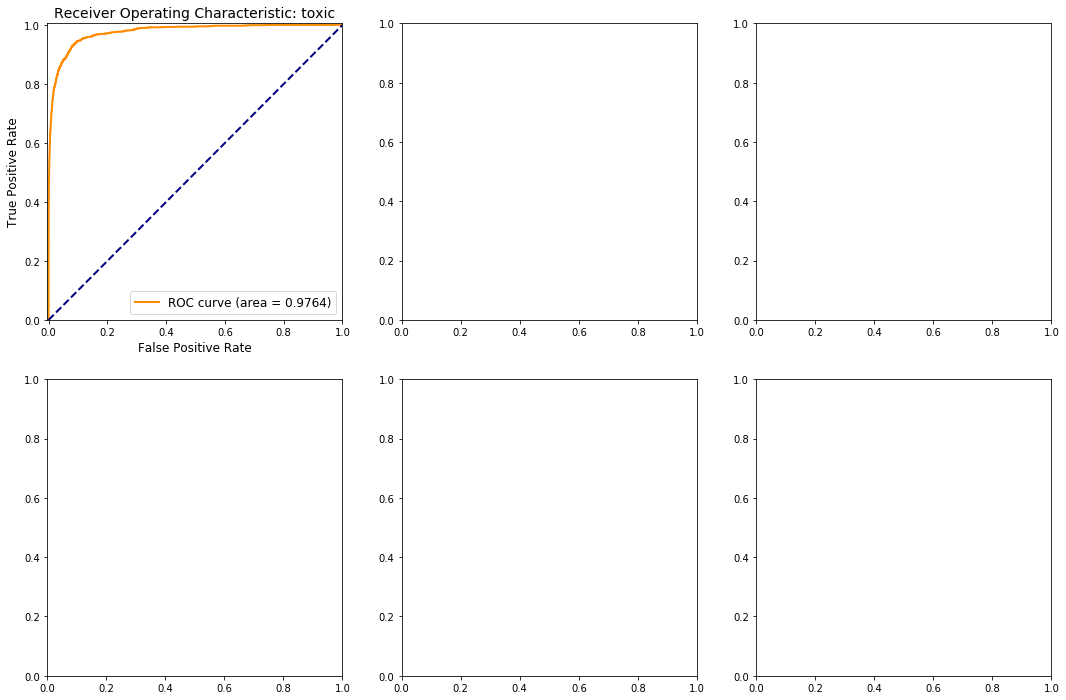

In [39]:
c_names = ["toxic", "severe_toxic", "obscene", "theat", "insult", "identity_hate"]

fig, axs = plt.subplots(2, 3, figsize=(18,12))

fig.set_facecolor("white")

for _c in range(1):
    class_index = _c
    class_name = c_names[_c]

    result = roc_auc_score(y_val, val_preds)

    fpr = {}
    tpr = {}
    fpr, tpr, _ = roc_curve(y_val, val_preds)
    roc_auc = auc(fpr, tpr)

    # print(fpr)
    print(result)

    ax = axs.flatten()[_c]

    ax.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc)


    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([-0.005, 1.0])
    ax.set_ylim([0.0, 1.005])
    ax.set_xlabel('False Positive Rate', size=12)
    ax.set_ylabel('True Positive Rate', size=12)
    ax.set_title('Receiver Operating Characteristic: ' + class_name, size=14)
    ax.legend(loc="lower right", fontsize=12)
    # plt.show()